In [3]:
import sympy as sp
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp

from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import firFilter, pnorm
from optic.metrics import signal_power
from optic.plot import pconst
from numba import njit

In [14]:
@njit
def viterbi(A, C, B, O):
    """Viterbi algorithm for solving the uncovering problem

    Notebook: C5/C5S3_Viterbi.ipynb

    Args:
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution  of dimension I
        B (np.ndarray): Output probability matrix of dimension I x K
        O (np.ndarray): Observation sequence of length N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        D (np.ndarray): Accumulated probability matrix
        E (np.ndarray): Backtracking matrix
    """
    I = A.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence

    # Initialize D and E matrices
    D = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D[:, 0] = np.multiply(C, B[:, O[0]])

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(I):
            temp_product = np.multiply(A[:, i], D[:, n-1])
            D[i, n] = np.max(temp_product) * B[i, O[n]]
            E[i, n-1] = np.argmax(temp_product)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    return S_opt, D, E

def dec2bit(dec, bitL):
    bits = bin(dec)[2:]  # Convert decimal to binary string
    bits = bits.zfill(bitL)  # Pad with leading zeros
    return [int(bit) for bit in bits]

def prob(y, r, σ2):
    prob = np.zeros((len(r), len(y)))
    
    for k, v in enumerate(y):
        prob[:,k] = np.abs(v-r)**2/σ2
        
    return prob

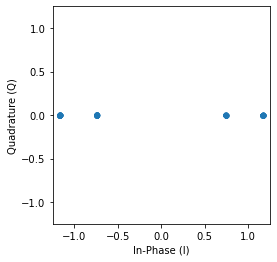

In [19]:
M = 2

h = np.array([0.9, 0.2])
constSymb = GrayMapping(M, 'pam')   # Gray constellation mapping

# parâmetros da simulação
SpS = 1   # Amostras por símbolo

# get constellation    
constSymb = GrayMapping(M, 'pam')  # constellation
constSymb = pnorm(constSymb) 

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(1001*np.log2(M)))

# generate modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# adição de ISI
sigTx = np.convolve(h, symbTx, mode='valid')
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.000025 # variância
μ   = 0      # média

σ      = np.sqrt(σ2*SpS) 
ruido  = 1/np.sqrt(2)*(normal(μ, σ, Namostras) + 1j*normal(μ, σ, Namostras))

sigRx = sigTx + ruido

pconst(sigRx, pType='fast');

In [20]:
L = len(h)
bits = np.zeros((M**L, L), dtype=int)

for k, dec in enumerate(range(M**L)):    
    bits[k,:] = dec2bit(dec, L)

symb = 2*bits-1

x = np.sum(symb*h, axis=1)

sig = pd.DataFrame(data=symb, index=np.arange(M**L))
pd.options.display.float_format = '{:,.2f}'.format

sig = pd.DataFrame(data=bits, index=[i for i in range(symb.shape[0])], columns=[f'b{-i}' for i in range(symb.shape[1])])
sig['r'] = x
sig

,b0,b-1,r
0,0,0,-1.10
1,0,1,-0.70
2,1,0,0.70
3,1,1,1.10


In [21]:

A = 0.5*np.ones((2,2))

p_ch = prob(sigRx, x, σ2)

In [22]:
p_ch.shape

(4, 1000)

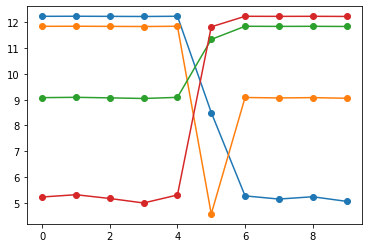

In [26]:
plt.plot(np.log(p_ch[:,0:10]).T,'-o');

In [28]:
bitsTx[0:10]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0])